# Background
This notebook goes through the off position reduction in class for the orion B map
The notebook will work through the following demos:
   * download datas from the archive
   * open class file and examine contents

In [1]:
from IPython.display import HTML

HTML('''
// http://lokeshdhakar.com/projects/lightbox2
<link href="./notebook_support/lightbox2-master/dist/css/lightbox.css" rel="stylesheet">

<script src="./notebook_support/lightbox2-master/dist/js/lightbox.js"></script>

<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

# import commands

In [2]:
!pip install spectral_cube

In [3]:
## import
from astropy.io import fits

import numpy as np
import glob
import datetime
import pandas as pd
import logging
import os,re
import time
import subprocess
import cygrid
from astropy.wcs import WCS
%matplotlib inline
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube
from matplotlib.lines import lineStyles
from astropy.io import fits
from astropy import units as u
import jinja2
import requests
#
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.io import fits
# notebook
from IPython.display import Image, display
from IPython.display import HTML
# astropy
from astropy.io import fits
from astropy import constants as const
from astropy import units as u

plt.rcParams['figure.figsize'] = (15.0, 7.0)

def PrintMessage(message):
    html='''
    <table style="width:100%">
        <tr>
            <td style='text-align:center;vertical-align:middle'>{0}</td>
        </tr>
    </table>
    '''
    display(HTML(html.format(message)))


def Change1dListTo2dList(array, column=2):
    test = []
    test_row = []
    for item in array:
        test_row.append(item)
        if len(test_row)> column-1:
            test.append(test_row)
            test_row = []
    if len(test_row)>0:
        test.append(test_row)
    return test

def DisplayImagesInColumns(images,image_columns=2, gallery_label=""):
    popup_css='''    
    
    <style>
    .thumb img { 
        border:1px solid #000;
        margin:3px;    
        float:left;
    }
    .thumb span { 
        position:fixed;
        visibility:hidden;
    }
    .thumb:hover, .thumb:hover span { 
        visibility:visible;
        z-index:1;
    }

    </style>

    '''
    
    html='''    
    <a href={0} target="_blank">
    <img style='width: {1:2.0f}%; margin: 0px; float: left; border: 0px solid black;' src='{0}?{2}' />
    </a>
    '''
    html='''    
    <a href={0}  target="_blank">
    <img style='width: {1:2.0f}%; margin: 0px; float: left; border: 0px solid black;' src='{0}?{2}' />
    </a>
    '''
    
    #html='''    
    #<a href={0}  data-lightbox={3} data-title="{0}">
    #<img style='width: {1:2.0f}%; margin: 0px; float: left; border: 0px solid black;' src='{0}?{2}' />
    #</a>
    #'''
    
    list2d = Change1dListTo2dList(images, column=image_columns)
    width_percent = (1/float(image_columns))*100.0
    gallery_label = gallery_label.replace(" ","")
    for row in list2d:
        imagesList=popup_css.join( [html.format(image,width_percent-2,time.time(),gallery_label) 
                     for image in row ])
        display(HTML(imagesList))
    return imagesList
   

# Helper Class to run class_cmd_strings and export the images that were created to the notebook
class RunClassScript():
    def __init__(self, cmd, no_output=False, display_images=True, test=False):
        self.cmd = cmd
        self.cmd_file = "/tmp/cmd.class"
        self.cmd_log = "/tmp/cmd.log"
        self.images = [string.split()[1].replace("\"","").replace("//","/") for string in self.cmd.split("\n") if string[0:2] == "ha"]
        if self.cmd.split("\n")[-1].strip() != "exit 0":
            self.cmd = "{}\nexit 0\n".format(self.cmd)
        subprocess.call(["rm", "-rf", "/tmp/cmd.class"])
        fileout = open(self.cmd_file, "w")
        fileout.write(self.cmd)
        fileout.close()
        #output = subprocess.check_output("class -nw @{0}".format(self.cmd_file), shell=True)
        if test:
            print(self.cmd)
        try:
            output = subprocess.check_call("class  @{0} > {1}".format(self.cmd_file,self.cmd_log), shell=True)
        except subprocess.CalledProcessError as e:
            print("======================================")
            print("=========== ERROR in class cmd =======")
            print("======================================")
            print("\n")
            print("======================================")
            print("============= INPUT FILE =============")
            print("======================================")
            with open(self.cmd_file, 'r') as fin:
                for line in fin.readlines():
                    if line[0]!=" ":
                        print(line.strip("\n"))
            print("======================================")
            print("========= OUTPUT LOGFILE =============")
            print("======================================")                        
            with open(self.cmd_log, 'r') as fin:
                for line in fin.readlines()[-300:]:
                    if (len(set(line))>1):
                        print(line.strip("\n"))
            raise subprocess.CalledProcessError(e.returncode,e.cmd, e.output)
        if output!=0:
            print(output)
            self.output=output
        #
        if display_images:
            for image in self.images:
                if os.path.exists(image):
                    #display(image, Image(image),width=300,height=300)
                    display(image, Image(image))
def GenerateGIFAnimation(images,gif_filename):
    convert_cmd = "convert -delay 50"\
                  " -loop 0 "\
                  "{0} "\
                  "{1}".format(images,gif_filename)
    os.system(convert_cmd)
    

    from IPython.display import HTML

def download_file(url,local_filename):
    #local_filename = url.split('/')[-1]
    r = requests.get(url)
    f = open(local_filename, 'wb')
    for chunk in r.iter_content(chunk_size=512 * 1024): 
        if chunk: # filter out keep-alive new chunks
            f.write(chunk)
    f.close()
    return 

def show_file_content(file, num_lines:int=0,with_line_numbers:bool=False):
    ''' To show class console output '''
    a_file = open(file, "r")
    lines = a_file.readlines()
    last_lines= lines[-num_lines:]    
    for i,line in enumerate(last_lines):
        string=line.strip
        if with_line_numbers:
            print(f'{i} {line}', end="")
        else:
            print(line.strip("\n"))

In [4]:
%%html
<style>
table {align:left;display:block}
</style>

# Download test data from archive



In these examples we'll download level 3 data from the archive, first go to the ISRA archive page:
https://irsa.ipac.caltech.edu/applications/sofia/?__action=layout.showDropDown&view=Search


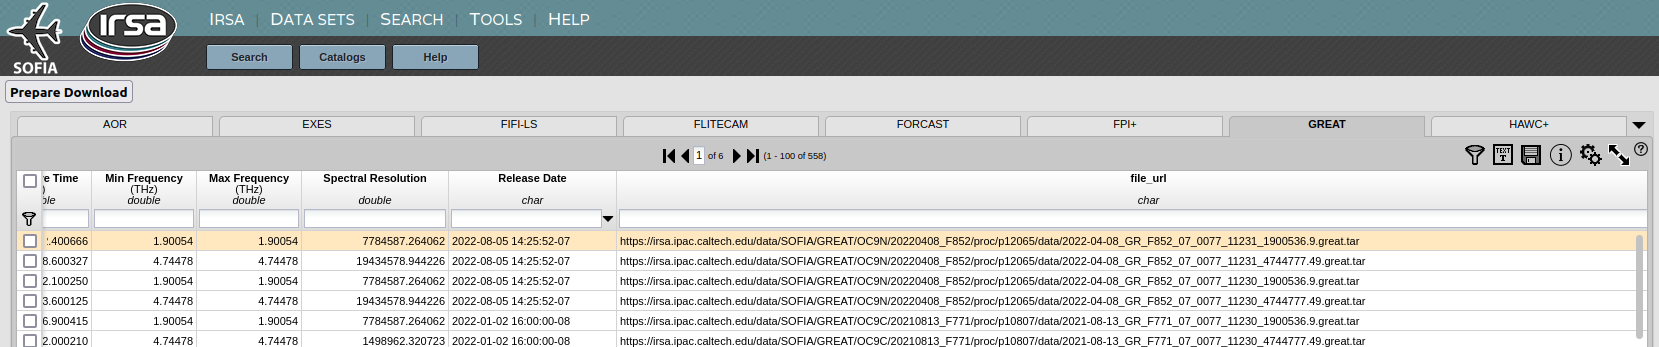


In [5]:
data_folder = "./tmp/data"


if not os.path.exists(data_folder):
    print("making folder {0}".format(data_folder))
    #os.makedirs(data_folder)
    os.makedirs(data_folder,exist_ok=True)
    
urls = []
urls.append("https://irsa.ipac.caltech.edu/data/SOFIA/GREAT/OC4K/20161110_F348/proc/p8486/data/2016-11-10_GR_F348_04_0066_0010505_1900536.9.great.tar")
urls.append("https://irsa.ipac.caltech.edu/data/SOFIA/GREAT/OC5A/20170208_F371/proc/p4006/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9.great.tar")
urls.append("https://irsa.ipac.caltech.edu/data/SOFIA/GREAT/OC9C/20210807_F766/proc/p10803/data/2021-08-07_GR_F766_07_0077_09221_1900536.9.great.tar")

for url in urls:
    filename = "{0}/{1}".format(data_folder,url.split('/')[-1])
    if not os.path.exists(filename):
        print("downloading {0} to {1}".format(url, filename))
        download_file(url, filename)
    else:
        print("{1} already downloaded".format(url, filename))
# untar
already_downloaded_great = glob.glob("tmp/data/**/*.great")
#
for url in urls:
    # check for great file
    tar_filename = "{0}/{1}".format(data_folder,url.split('/')[-1])
    filename_great,ext = os.path.splitext(tar_filename)
    full_filename_great,ext = os.path.splitext(os.path.basename(filename_great))
    #
    found = [filename for filename in  already_downloaded_great if full_filename_great in filename]
    if len(found)>0:
        print(" {0} already extracted".format(full_filename_great))
    else:
        print(" {0} extracting".format(full_filename_great))
        #cmd="tar -xvf {0} --wildcards --no-anchored '*Tmb.great' --one-top-level={1}".format(tar_filename,data_folder)
        cmd="tar -xvf {0} --one-top-level={1}".format(tar_filename, data_folder)
        print(cmd)
        output = subprocess.check_call(cmd, shell=True)

./tmp/data/2016-11-10_GR_F348_04_0066_0010505_1900536.9.great.tar already downloaded
./tmp/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9.great.tar already downloaded
./tmp/data/2021-08-07_GR_F766_07_0077_09221_1900536.9.great.tar already downloaded
 2016-11-10_GR_F348_04_0066_0010505_1900536.9 already extracted
 2017-02-08_GR_F371_04_0066_0010505_1900536.9 already extracted
 2021-08-07_GR_F766_07_0077_09221_1900536.9 already extracted


#  THE DATA PRODUCTS  IN THE ARCHIVE #
## LEVEL 3 DATA 
  * Level 3 data contains fully calibrated spectra hand reduced by the GREAT team
  * produced by the calibration program kalibrate from level 1 data 

The Downloaded data contains 2 **.great** files: 

 * Scientific target spectra in units of Antenna Temperature and additional output spectra.
 * Scientific target spectra only, in units of Main Beam Temperature.


### Antenna Temperature file
Let's open the Tant file and look at the data.
For ease of display, the notebook runs class script below, the class output is captured by the python routine and can be displayed to screen, see an example below using the list /toc function

In [212]:
input_filename = os.path.abspath("./tmp/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9/2017-02-08_GR_F371_04_0066_0010505_1900536.9_Tmb.great")
#input_filename = os.path.abspath("./tmp/data/2021-08-07_GR_F766_07_0077_09221_1900536.9/2021-08-07_GR_F766_07_0077_09221_1900536.9_Tant.great")
print(os.path.exists(input_filename))
cmd = f'''
file in "{input_filename}"
find
list /toc source
'''
output = RunClassScript(cmd)
show_file_content('/tmp/cmd.log', 28,with_line_numbers=False)

True
I-FIND,  15848 observations found
Current index contains:
Number of sources......  12
   TREC (SSB)            42 (  0.3%)
   OMC_CENTER         14112 ( 89.0%)
   CAL_SIG              196 (  1.2%)
   CAL_IMG              196 (  1.2%)
   TSYS                 196 (  1.2%)
   TAU_SIG              196 (  1.2%)
   TAU_IMG              196 (  1.2%)
   TAU_AVG              196 (  1.2%)
   S-H_OBS              168 (  1.1%)
   S-H_FIT              168 (  1.1%)
   SKY-DIFF             154 (  1.0%)
   HOT-COLD              28 (  0.2%)
Number of setups.......  12
   TREC (SSB)            42 (  0.3%)
   OMC_CENTER         14112 ( 89.0%)
   CAL_SIG              196 (  1.2%)
   CAL_IMG              196 (  1.2%)
   TSYS                 196 (  1.2%)
   TAU_SIG              196 (  1.2%)
   TAU_IMG              196 (  1.2%)
   TAU_AVG              196 (  1.2%)
   S-H_OBS              168 (  1.1%)
   S-H_FIT              168 (  1.1%)
   SKY-DIFF             154 (  1.0%)
   HOT-COLD              28 ( 

## spectra names breakdown

|Name|Description| Uses| 
|:---|:---------|:-----|
|TREC (SSB)| receiver temperature| check instrument and pixel performance/sensitivity | 
|RCW79| astronomical data| |
|TSYS| system temperature (including atmospheric affects)| Check ATM affects on sensitivity (compared to TREC)|
|TAU_SIG| Atmospheric transmission in signal side band | |
|TAU_IMG| Atmospheric transmission in image side band  | |
|TAU_AVG| Average atmospheric transmission | |
|S-H_OBS| Off-Hot spectra used for atmospheric fitting | if suspicious of transmission values check data quality here|
|S-H\_FIT| Atmospheric model fit to S-H\_OBS| Check fit match S-H_OBS spectra, check frequencies correct (for HFAV useful where QCL LO frequency drift could be an issue)|
|SKY-DIFF| Difference between subsequenct OFF spectra | Useful to check based quality, input for spline and PCA fitting methods|
|HOT-COLD| Temperature calibrate spectra from the HOT-COLD | check temperature difference between the Hot and COLD, useful debug for system response |





## examples of different spectra products

Below is a class script to programmatically go through the file index and generate plots for each pixel.
You can use the **list /toc** function to group the spectra and extract the pixel names to a variable. You can then loop over this array to make plots per spectra.

In [198]:

cmd ='''
file in "{input_filename}"

def struct telescopes
find
list /toc tel /variable telescopes
set source {source}*
find
set unit v
set mode x {x_limits}
set nomatch
set weight equal
set nocheck cal
set mode y {y_limits}
for tel_nb 1 to telescopes%ntele
   say 'telescopes%tele[tel_nb]'
   find /tel 'telescopes%tele[tel_nb]'
   !
   if found.ne.0 then
      average
   endif
   smooth box {smooth_box}
   pen 'mod(tel_nb,7)'
   if tel_nb.eq.1 then
      pen 0
      plot
   else
      spec
   endif
next
!get f
!pl
ha "./tmp/average_{source}_per_pixel.png" /dev png /overwrite

! show all TRECS per pixel in one plot
for tel_nb 1 to telescopes%ntele
   say 'telescopes%tele[tel_nb]'
   find /tel 'telescopes%tele[tel_nb]'
   !
   pen 'mod(tel_nb,7)'
   for i 1 to found
       get n
       smooth box {smooth_box}
       if tel_nb.eq.1 then
          pen 0
          plot
       else
          spec
       endif
   next
next
!get f
!pl
ha "./tmp/{source}_per_pixel.png" /dev png /overwrite
'''
source="TREC"
y_limits="1000 8000"
x_limits="-150 100" #km/s
smooth_box=2
output=RunClassScript(cmd.format(**locals()),display_images=False)
show_file_content('/tmp/cmd.log', 28,with_line_numbers=False)
DisplayImagesInColumns(output.images,image_columns=2, gallery_label="Left (averaged TREC per pixel, all TREC spectra )")


I-GET,  Observation 15826; Vers 5 Scan 18251
I-WRITE,  Observation #15826;6 successfully written
I-GET,  Observation 15827; Vers 5 Scan 18251
I-WRITE,  Observation #15827;6 successfully written
I-GET,  Observation 15828; Vers 5 Scan 18251
I-WRITE,  Observation #15828;6 successfully written
I-GET,  Observation 15829; Vers 5 Scan 18251
I-WRITE,  Observation #15829;6 successfully written
I-GET,  Observation 15830; Vers 5 Scan 18251
I-WRITE,  Observation #15830;6 successfully written
I-GET,  Observation 15831; Vers 5 Scan 18251
I-WRITE,  Observation #15831;6 successfully written
I-GET,  Observation 15832; Vers 5 Scan 18251
I-WRITE,  Observation #15832;6 successfully written
I-GET,  Observation 15833; Vers 5 Scan 18251
I-WRITE,  Observation #15833;6 successfully written
I-GET,  Observation 15834; Vers 5 Scan 18251
I-WRITE,  Observation #15834;6 successfully written
I-GET,  Observation 15835; Vers 5 Scan 18251
I-WRITE,  Observation #15835;6 successfully written
I-GET,  Observation 15836; Ver

'    \n    <a href=./tmp/average_TREC_per_pixel.png  target="_blank">\n    <img style=\'width: 48%; margin: 0px; float: left; border: 0px solid black;\' src=\'./tmp/average_TREC_per_pixel.png?1682089805.729106\' />\n    </a>\n        \n    \n    <style>\n    .thumb img { \n        border:1px solid #000;\n        margin:3px;    \n        float:left;\n    }\n    .thumb span { \n        position:fixed;\n        visibility:hidden;\n    }\n    .thumb:hover, .thumb:hover span { \n        visibility:visible;\n        z-index:1;\n    }\n\n    </style>\n\n        \n    <a href=./tmp/TREC_per_pixel.png  target="_blank">\n    <img style=\'width: 48%; margin: 0px; float: left; border: 0px solid black;\' src=\'./tmp/TREC_per_pixel.png?1682089805.7291236\' />\n    </a>\n    '

## example TSYS spectrum ##

In [8]:
source="TSYS"
y_limits="1000 8000"
x_limits="-150 100" #km/s
smooth_box=2
output=RunClassScript(cmd.format(**locals()),display_images=False)
#show_file_content('/tmp/cmd.log', 28,with_line_numbers=False)
DisplayImagesInColumns(output.images,image_columns=2, gallery_label="Left (averaged TREC per pixel, all TREC spectra )")

'    \n    <a href=./tmp/average_TSYS_per_pixel.png  target="_blank">\n    <img style=\'width: 48%; margin: 0px; float: left; border: 0px solid black;\' src=\'./tmp/average_TSYS_per_pixel.png?1682077213.5054808\' />\n    </a>\n        \n    \n    <style>\n    .thumb img { \n        border:1px solid #000;\n        margin:3px;    \n        float:left;\n    }\n    .thumb span { \n        position:fixed;\n        visibility:hidden;\n    }\n    .thumb:hover, .thumb:hover span { \n        visibility:visible;\n        z-index:1;\n    }\n\n    </style>\n\n        \n    <a href=./tmp/TSYS_per_pixel.png  target="_blank">\n    <img style=\'width: 48%; margin: 0px; float: left; border: 0px solid black;\' src=\'./tmp/TSYS_per_pixel.png?1682077213.505503\' />\n    </a>\n    '

## example TAU_SIGNAL spectra ##

In [9]:
source="TAU_SIG"
y_limits="0.12 1.0"
x_limits="-150 100" #km/s
smooth_box=2
output=RunClassScript(cmd.format(**locals()),display_images=False)
#show_file_content('/tmp/cmd.log', 28,with_line_numbers=False)
DisplayImagesInColumns(output.images,image_columns=2, gallery_label="Left (averaged TREC per pixel, all TREC spectra )")

'    \n    <a href=./tmp/average_TAU_SIG_per_pixel.png  target="_blank">\n    <img style=\'width: 48%; margin: 0px; float: left; border: 0px solid black;\' src=\'./tmp/average_TAU_SIG_per_pixel.png?1682077214.4098585\' />\n    </a>\n        \n    \n    <style>\n    .thumb img { \n        border:1px solid #000;\n        margin:3px;    \n        float:left;\n    }\n    .thumb span { \n        position:fixed;\n        visibility:hidden;\n    }\n    .thumb:hover, .thumb:hover span { \n        visibility:visible;\n        z-index:1;\n    }\n\n    </style>\n\n        \n    <a href=./tmp/TAU_SIG_per_pixel.png  target="_blank">\n    <img style=\'width: 48%; margin: 0px; float: left; border: 0px solid black;\' src=\'./tmp/TAU_SIG_per_pixel.png?1682077214.409889\' />\n    </a>\n    '

## example SKY-OBS spectra

In [213]:
source="S-H_FIT"
y_limits="-350 -200"
x_limits="tot" #km/s
smooth_box=20
output=RunClassScript(cmd.format(**locals()),display_images=False)
#show_file_content('/tmp/cmd.log', 28,with_line_numbers=False)
DisplayImagesInColumns(output.images,image_columns=2)



UnboundLocalError: local variable 'imagesList' referenced before assignment

## example SKY-DIFF spectra

In [10]:
source="SKY-DIFF"
y_limits="-50 50"
x_limits="-150 100" #km/s
smooth_box=20
output=RunClassScript(cmd.format(**locals()),display_images=False)
#show_file_content('/tmp/cmd.log', 28,with_line_numbers=False)
DisplayImagesInColumns(output.images,image_columns=2, gallery_label="Left (averaged TREC per pixel, all TREC spectra )")



'    \n    <a href=./tmp/average_SKY-DIFF_per_pixel.png  target="_blank">\n    <img style=\'width: 48%; margin: 0px; float: left; border: 0px solid black;\' src=\'./tmp/average_SKY-DIFF_per_pixel.png?1682077215.8452907\' />\n    </a>\n        \n    \n    <style>\n    .thumb img { \n        border:1px solid #000;\n        margin:3px;    \n        float:left;\n    }\n    .thumb span { \n        position:fixed;\n        visibility:hidden;\n    }\n    .thumb:hover, .thumb:hover span { \n        visibility:visible;\n        z-index:1;\n    }\n\n    </style>\n\n        \n    <a href=./tmp/SKY-DIFF_per_pixel.png  target="_blank">\n    <img style=\'width: 48%; margin: 0px; float: left; border: 0px solid black;\' src=\'./tmp/SKY-DIFF_per_pixel.png?1682077215.8453112\' />\n    </a>\n    '

## example averaged of astronomical data

In [16]:

cmd ='''
file in "{input_filename}"

def struct telescopes
find
list /toc tel /variable telescopes
set source {source}*
find
set unit v
set mode x {x_limits}
set nomatch
set weight equal
set nocheck cal
set mode y {y_limits}

go where
ha "./tmp/sky_positions_{source}_per_pixel.png" /dev png /overwrite
for tel_nb 1 to telescopes%ntele
   say 'telescopes%tele[tel_nb]'
   find /tel 'telescopes%tele[tel_nb]'
   !
   if found.ne.0 then
      average
   endif
   smooth box {smooth_box}
   pen 'mod(tel_nb,7)'
   if tel_nb.eq.1 then
      pen 0
      plot
   else
      spec
   endif
next
!get f
!pl
ha "./tmp/average_{source}_per_pixel.png" /dev png /overwrite

'''
source="OMC"
y_limits="-25 20"
x_limits="-150 100" #km/s
smooth_box=20
print(cmd.format(**locals()))
output=RunClassScript(cmd.format(**locals()),display_images=False)
show_file_content('/tmp/cmd.log', 28,with_line_numbers=False)
DisplayImagesInColumns(output.images,image_columns=2, gallery_label="Left (averaged TREC per pixel, all TREC spectra )")



file in "/home/higgins/software/GREAT_data_reduction_notebook/tmp/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9/2017-02-08_GR_F371_04_0066_0010505_1900536.9_Tmb.great"

def struct telescopes
find
list /toc tel /variable telescopes
set source OMC*
find
set unit v
set mode x -150 100
set nomatch
set weight equal
set nocheck cal
set mode y -25 20

go where
ha "./tmp/sky_positions_OMC_per_pixel.png" /dev png /overwrite
for tel_nb 1 to telescopes%ntele
   say 'telescopes%tele[tel_nb]'
   find /tel 'telescopes%tele[tel_nb]'
   !
   if found.ne.0 then
      average
   endif
   smooth box 20
   pen 'mod(tel_nb,7)'
   if tel_nb.eq.1 then
      pen 0
      plot
   else
      spec
   endif
next
!get f
!pl
ha "./tmp/average_OMC_per_pixel.png" /dev png /overwrite


  Checking Position information
  Leaving  Offset position
  Checking Line Name
  Checking Spectroscopic information
  Leaving  Calibration information
  Checking Switching information
Reference spectrum:
  Source Name       : OMC_C

'    \n    <a href=./tmp/sky_positions_OMC_per_pixel.png  target="_blank">\n    <img style=\'width: 48%; margin: 0px; float: left; border: 0px solid black;\' src=\'./tmp/sky_positions_OMC_per_pixel.png?1682077298.0107265\' />\n    </a>\n        \n    \n    <style>\n    .thumb img { \n        border:1px solid #000;\n        margin:3px;    \n        float:left;\n    }\n    .thumb span { \n        position:fixed;\n        visibility:hidden;\n    }\n    .thumb:hover, .thumb:hover span { \n        visibility:visible;\n        z-index:1;\n    }\n\n    </style>\n\n        \n    <a href=./tmp/average_OMC_per_pixel.png  target="_blank">\n    <img style=\'width: 48%; margin: 0px; float: left; border: 0px solid black;\' src=\'./tmp/average_OMC_per_pixel.png?1682077298.010742\' />\n    </a>\n    '

# LEVEL 4 DATA#
## Consists of **.great** files that are a combination of level 3 data products ##
- Averaged spectra (**.great**)
- Datacubes (**.lmv**)

In [ ]:
show_file_content("/tmp/cmd.log",14)

In [ ]:
output=RunClassScript(cmd)

### Averaged Pixels  ###
### Horizontal and Vertical polarizations averaged together ###

In [ ]:
cmd='''
file in "./tmp/data/sofia_school_Tmb.great"
find

file out "./tmp/data/sofia_school_average_LFA_HVtogether.great" single /overwr

set align v
set nocheck
set telescope SOF-LFA*
find
for i 0 to 6
    set tele SOF-LFA*'i'*
    find
    average /resample
    wr
next

'''

In [ ]:
output=RunClassScript(cmd)

In [ ]:
cmd='''
file in "./tmp/data/sofia_school_average_LFA_HVtogether.great"
find 
list
'''

In [ ]:
output=RunClassScript(cmd)

In [ ]:
show_file_content("/tmp/cmd.log")

In [ ]:
cmd ='''
@kosma-init
file in "./tmp/data/sofia_school_average_LFA_HVtogether.great"
find
list

set unit v
set mod x -40 40
set mod y -30 130

plot_group /group_by telescope /group_by line /smooth 50 /base 3
ha "./plots/average_h_v.png" /dev png /overwr
'''

In [ ]:
output=RunClassScript(cmd)

# Converting K to Jy #

In [ ]:
cmd='''
@jansky 220 11 30
! frequency 220 GHz, beam size in arcsec
'''

In [ ]:
output=RunClassScript(cmd)

In [ ]:
show_file_content("/tmp/cmd.log", 3)

# DATACUBE CREATION IN CLASS #

In [44]:
cmd='''
file in "{input_filename}"
set tel {telescopes}
set source {source}
find

file out "./tmp/data/sofia_school_Tmb_base.great" mul /overwrite
for i 1 to found
   get n
   set window {window}
   base 3
   resample * * * {velocity_resolution} v
   write
next

file in "./tmp/data/sofia_school_Tmb_base.great"
find
set weight e

table "{cube_name}" new /range {cube_range} v /nocheck cal

let map%beam 15.1
let map%diam 2.5
let map%cell '-map%beam/4' 'map%beam/4'
let map%reso 'map%beam*1.05'

xy_map "{cube_name}"

let name "{cube_name}"
let type lmv

sys "rm -rf {cube_name}.fits"
vector\\fits {cube_name}.fits from {cube_name}.lmv
'''


In [45]:
source="OMC*"
cube_range="-40 40"
window=" -5 20"
telescopes = "SOF*"
cube_name="./tmp/data/sofia_school_map"
velocity_resolution=0.5
cubes = {}
#cubes["H_cube"] = {"telescopes" : "SOF*LFAH*", "cube_name" : "./tmp/data/sofia_school_map_H"}
cubes["V_cube"] = {"telescopes" : "SOF*LFAV*", "cube_name" : "./tmp/data/sofia_school_map_V"}
#cubes["HV_cube"] = {"telescopes" : "SOF*LFA*", "cube_name" : "./tmp/data/sofia_school_map"}
for cube_name, params in cubes.items():
    print("processing ",cube_name,params)
    telescopes = params["telescopes"]
    cube_name = params["cube_name"]
    output=RunClassScript(cmd.format(**locals()))

processing  V_cube {'telescopes': 'SOF*LFAV*', 'cube_name': './tmp/data/sofia_school_map_V'}


In [24]:
cube_fits_filename="./tmp/data/sofia_school_map.fits"

cmd='''
sys "rm {cube_fits_filename}"
vector\\fits {cube_fits_filename} from ./tmp/data/sofia_school_map.lmv
'''
output=RunClassScript(cmd.format(**locals()))

True
sofia_school_map.fits


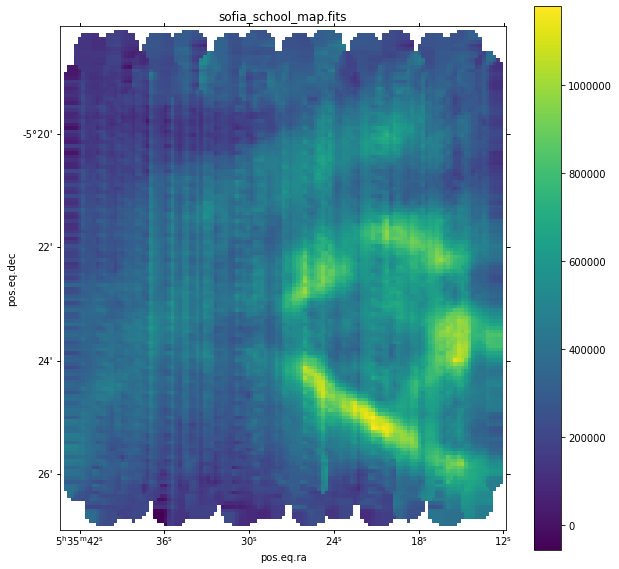

In [46]:
SpectralCube.read(cube_fits_filename)
#
max_vel = -5
min_vel = 15
limits = (min_vel,max_vel)
limits = limits*u.km/u.s
import glob
filename = "./tmp/data/sofia_school_map.fits"
print(os.path.exists(filename))
cubes={}
cubes[os.path.basename(filename)] = SpectralCube.read(filename)


for i,(line,cube) in enumerate(cubes.items()):
    print(line)
    image = cube.spectral_slab(min(limits),max(limits)).moment(order=0)    
    wcs = WCS(image.header)
    ax = plt.subplot(1,1,1, projection=wcs)
    cax = ax.imshow(image.data)
    cbar=plt.colorbar(cax, orientation='vertical')    
    #
    fig = ax.get_figure()
    fig.set_size_inches(10,10)
    ax.set_title(line)
    plt.show()

Text(0, 0.5, 'Antenna Temp (K)')

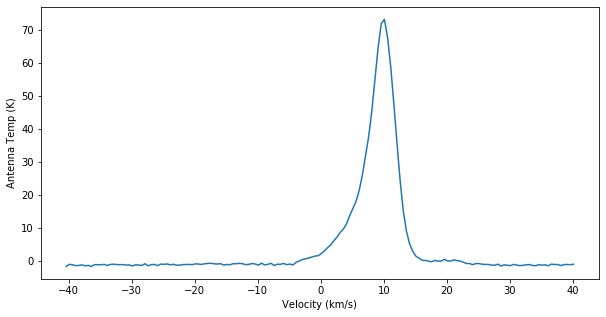

In [194]:
# average cube spectra
average_spectra_over_map = cube.mean(axis=(1, 2)) 
fig,ax = plt.subplots(1,1)
fig.set_size_inches(10,5)
ax.plot(cube.spectral_axis/1e3,average_spectra_over_map.data)
ax.set_xlabel("Velocity (km/s)")
ax.set_ylabel("Antenna Temp (K)")


# WORKING with SD FITS from class 

Working with SD fits opens up other tools which can give a more flexible environment such as 
  * CASA
  * GBT suite of tools
  * ASAP (ATNF Spectral Analysis Package)
  * astropy fits table tools (demoed here)


In [140]:
cmd='''
set angle sec
file in "{input_filename}"
file out "tmp/data/sofia_school_Tmb_resample.great" single /overwrite
find
for i 1 to found 
   get n
   extract {vel_range} v
   resample * * * {vel_res} v 
   write
next

file in "tmp/data/sofia_school_Tmb_resample.great"
find
sys "rm ./tmp/data/sofia_school_Tmb_index.fits"
fits write "./tmp/data/sofia_school_Tmb_index.fits" /mode index 
'''
vel_range="-40 40"
vel_res=0.5
output=RunClassScript(cmd.format(**locals()))

In [164]:



def load_and_fix_fits_hdu(fits_file):
    hdu = fits.open(fits_file)    
    if hdu[0].header['NAXIS']==4:
        for key in  hdu[0].header.keys():
            if (key[-1] == "3") or (key[-1] == "4"):
                hdu[0].header.__delitem__(key)
        if "RA" not in  hdu[0].header["CTYPE1"]:
            hdu[0].header["CTYPE1"] = "RA---GLS"
        if "DEC" not in hdu[0].header["CTYPE2"]:
            hdu[0].header["CTYPE2"] = "DEC--GLS"
        # fix data
        hdu[0].header['NAXIS']=2
        data = np.array(hdu[0].data[0,0,:,:],dtype='float64')
        #index_lt_zero =np.where(data <= 0.0)
        #data[index_lt_zero] = 0.0
        hdu[0].data = data
    return hdu

def add_subplot_axes(ax,rect):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    #x_labelsize *= rect[2]**0.5
    #y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

def generate_velocity_axis(fits_table):
    if type(fits_table) != Table.Row:
        print("only astropy row supported")
        return
    DELTAV = (fits_table["DELTAV"] if "DELTAV" in fits_table.columns else fits_table.meta["DELTAV"])*u.m/u.s
    CRPIX1 = fits_table["CRPIX1"] if "CRPIX1" in fits_table.columns else fits_table.meta["CRPIX1"]
    MAXIS1 = len(fits_table["SPECTRUM"])
    VELO_LSR = (fits_table["VELO-LSR"] if "VELO-LSR" in fits_table.columns else fits_table.meta["VELO-LSR"])*u.m/u.s
    if MAXIS1!=len(fits_table["SPECTRUM"]):
        print("({0[MAXIS1]})MAXIS1 ({0[MAXIS1]}) not equal to spectrum channel number ({1})".format(fits_table,
                                                                               len(fits_table["SPECTRUM"])))
    #
    # fits scales start at 1
    velocity = (np.arange(MAXIS1)-CRPIX1+1)*DELTAV + VELO_LSR    
    return velocity  


#
# add additional columns to fits table
# rms, max,min,median,integrated_intensity
#
def add_descriptive_columns(fits_table,max_vel=None,min_vel=None,columns=["integrated_intensity","stats"]):
    #
    if "integrated_intensity" in columns:
        fits_table["integrated_intensity"] = 0.0
    if "stats" in columns:
        for column in ["rms","mean","median","max","min"]:
            fits_table[column] = 0.0
    fits_table["integrated_intensity"].meta = {"max_veloicity" : max_vel,
                                               "min_veloicity" : min_vel
                                              }
    if max_vel is not None:
        max_vel = max_vel.to(u.m/u.s)
    if min_vel is not None:        
        min_vel = min_vel.to(u.m/u.s)
    #
    for i,spectra in enumerate(fits_table):
        if i%10000 == 0:
            print(f'processing {i}/{len(fits_table)}')
        if max_vel is not None:
            velocity = generate_velocity_axis(spectra)
            #
            index_line = np.where(np.logical_and(velocity>=min_vel, velocity<=max_vel))
            index_int = np.where(~np.logical_and(velocity>=min_vel, velocity<=max_vel))
            spectra_indexed = spectra["SPECTRUM"][index_int]
            spectra_line = spectra["SPECTRUM"][index_line]
        else:
            spectra_indexed = spectra["SPECTRUM"]
        #
        if "integrated_intensity" in columns:
            line_int = np.nansum(spectra_line)
            spectra["integrated_intensity"] = line_int
        if "stats" in columns:
            spectra["rms"] = np.nanstd(spectra_indexed)
            spectra["mean"] = np.nanmean(spectra_indexed)
            spectra["median"] = np.nanmedian(spectra_indexed)
            spectra["max"] = np.nanmax(spectra_indexed)
            spectra["min"] = np.nanmin(spectra_indexed)
#


#
fits_data="./tmp/data/sofia_school_Tmb_index.fits"
#
fits_table = Table.read(fits_data,memmap=True)
velocity=generate_velocity_axis(fits_table[0])
lower_line_win = -5e3*u.m/u.s
upper_line_win = 10e3*u.m/u.s

add_descriptive_columns(fits_table,upper_line_win,lower_line_win)

processing 0/15848
processing 10000/15848


## RMS histogram per array

b'SOF-LFAH_0_S'
b'SOF-LFAH_1_S'
b'SOF-LFAH_2_S'
b'SOF-LFAH_3_S'
b'SOF-LFAH_4_S'
b'SOF-LFAH_5_S'
b'SOF-LFAH_6_S'
b'SOF-LFAV_0_S'
b'SOF-LFAV_1_S'
b'SOF-LFAV_2_S'
b'SOF-LFAV_3_S'
b'SOF-LFAV_4_S'
b'SOF-LFAV_5_S'
b'SOF-LFAV_6_S'


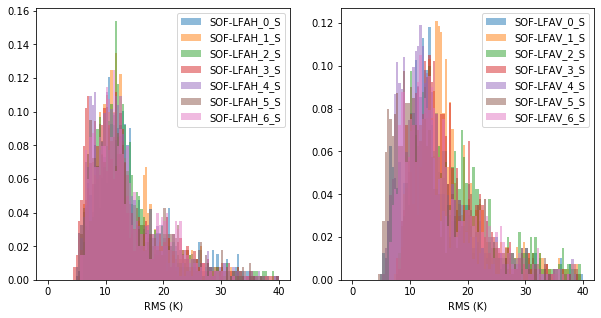

In [175]:
# plot rms per pixel
pandas_table = fits_table[[col for col in list(fits_table.columns) if col != "SPECTRUM"]].to_pandas()
#
fig,axes = plt.subplots(1,2)
fig.set_size_inches(10,5)
axes_dict=dict(zip(["H","V"],axes))
for telescope, table_tel in pandas_table.groupby(["TELESCOP"]):
    print(telescope)
    table_source = table_tel[table_tel["OBJECT"].astype(str).str.contains("OMC")]
    if "LFAH_" in str(telescope):
        ax = axes_dict["H"]
    else:
        ax = axes_dict["V"]
    #print(telescope,table_source.rms.max(),table_source.rms.min())
    ax.hist(table_source.rms.dropna(),bins=100, range=(0,40),
            density=True,label=telescope.decode("utf-8"),alpha=0.5)
    ax.legend()
    ax.set_xlabel("RMS (K)")



## RMS histogram per pixel

b'SOF-LFAH_0_S'
b'SOF-LFAH_1_S'
b'SOF-LFAH_2_S'
b'SOF-LFAH_3_S'
b'SOF-LFAH_4_S'
b'SOF-LFAH_5_S'
b'SOF-LFAH_6_S'
b'SOF-LFAV_0_S'
b'SOF-LFAV_1_S'
b'SOF-LFAV_2_S'
b'SOF-LFAV_3_S'
b'SOF-LFAV_4_S'
b'SOF-LFAV_5_S'
b'SOF-LFAV_6_S'


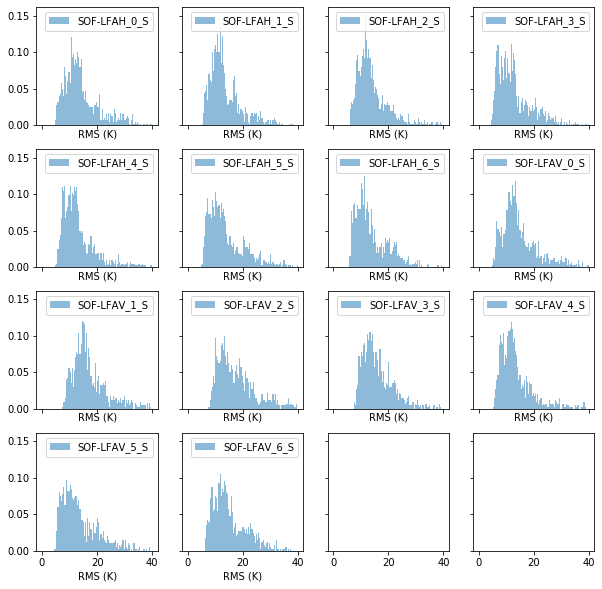

In [178]:
# per pixel for clarity
# plot rms per pixel
#
fig,axes = plt.subplots(4,4,sharex=True,sharey=True)
fig.set_size_inches(10,10)
axes_dict=dict(zip(pandas_table["TELESCOP"].unique(),axes.flatten()))
for telescope, table_tel in pandas_table.groupby(["TELESCOP"]):
    print(telescope)
    table_source = table_tel[table_tel["OBJECT"].astype(str).str.contains("OMC")]
    ax = axes_dict[telescope]
    #print(telescope,table_source.rms.max(),table_source.rms.min())
    ax.hist(table_source.rms.dropna(),bins=100, range=(0,40),
            density=True,label=telescope.decode("utf-8"),alpha=0.5)
    ax.legend()
    ax.set_xlabel("RMS (K)")



## RMS time line

b'SOF-LFAH_0_S'
b'SOF-LFAH_1_S'
b'SOF-LFAH_2_S'
b'SOF-LFAH_3_S'
b'SOF-LFAH_4_S'
b'SOF-LFAH_5_S'
b'SOF-LFAH_6_S'
b'SOF-LFAV_0_S'
b'SOF-LFAV_1_S'
b'SOF-LFAV_2_S'
b'SOF-LFAV_3_S'
b'SOF-LFAV_4_S'
b'SOF-LFAV_5_S'
b'SOF-LFAV_6_S'


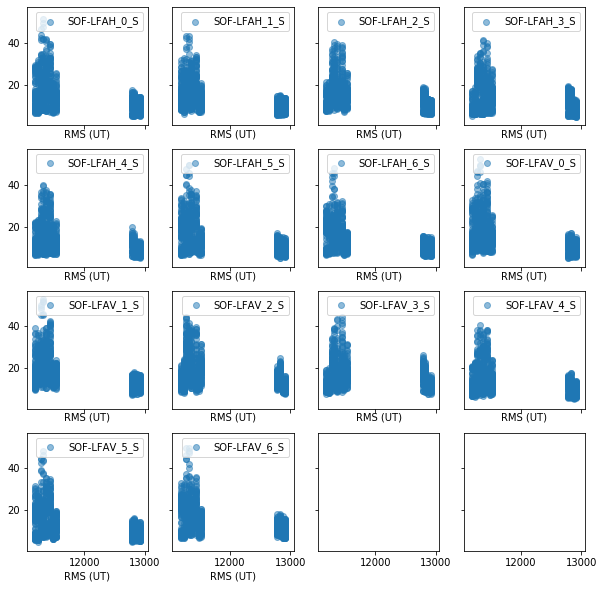

In [187]:
pandas_table["UT"]
# per pixel for clarity
# plot rms per pixel
#
fig,axes = plt.subplots(4,4,sharex=True,sharey=True)
fig.set_size_inches(10,10)
axes_dict=dict(zip(pandas_table["TELESCOP"].unique(),axes.flatten()))
for telescope, table_tel in pandas_table.groupby(["TELESCOP"]):
    print(telescope)
    table_source = table_tel[table_tel["OBJECT"].astype(str).str.contains("OMC")]
    ax = axes_dict[telescope]
    #print(telescope,table_source.rms.max(),table_source.rms.min())
    ax.scatter(table_source["UT"],table_source.rms,label=telescope.decode("utf-8"),alpha=0.5)
    ax.legend()
    ax.set_xlabel("TIME (UT)")
    ax.set_xlabel("RMS (UT)")



In [ ]:
# timeline of spectra


## Cygrid  

### Creating the fits file from class ###

In [101]:
cmd='''
set angle sec
file in "{input_filename}"
file out "tmp/data/sofia_school_Tmb_resample.great" single /overwrite
find
for i 1 to found 
   get n
   extract {vel_range} v
   resample * * * {vel_res} v 
   write
next

file in "tmp/data/sofia_school_Tmb_resample.great"
find
sys "rm ./tmp/data/sofia_school_Tmb_index.fits"
fits write "./tmp/data/sofia_school_Tmb_index.fits" /mode index 
'''
vel_range="-40 40"
vel_res=0.5
output=RunClassScript(cmd.format(**locals()))

In [126]:



class Regridder:
    def __init__(self, fits_file,source):
        self.fits_file = fits_file
                 
        self.listremdframe = np.empty(0, dtype = int)
        self.lint = False                                                   
        self.rms = False
        #
        self.table=Table.read(filename,memmap=True)
        self.pandas_table = self.table[[col for col in list(self.table.columns) if col != "SPECTRUM"]].to_pandas()
        self.source_index=self.pandas_table["OBJECT"].astype(str).str.contains(source)
        self.channel_data = self.table['SPECTRUM'].data
        #
        crval2 = self.table.meta.get('CRVAL2',None)
        crval3 = self.table.meta.get('CRVAL3',None)
        if crval2 is None:
            crval2 = self.data['CRVAL2']
        if crval3 is None:
            crval3 = self.data['CRVAL3']
        #
        print(crval3)
        self.ra = crval2 + self.pandas_table['CDELT2']
        self.dec = crval3 + self.pandas_table['CDELT3']
        self.ra_min, self.ra_max = self.ra[source_index].min(), self.ra[source_index].max()
        self.dec_min, self.dec_max = self.dec[source_index].min(), self.dec[source_index].max()

        
    def _to_numpy(self):
        return np.array(self.data_fits.tolist())

    def _to_pandas(self):
        self.data = pd.DataFrame(data=self.data,
            columns=[self.data_fits.columns[i].name for i in range(len(self.data_fits.columns))])
        
    def cygrid_define(self, pixsize = 0.0004, kernelsize_sigma = 0.0002):
        '''cygrid params definition'''
        mapcenter = self.table.meta['CRVAL2'], self.table.meta['CRVAL3']  
        #
        dnaxis1 = int((self.ra.max() - self.ra.min())/pixsize)+1
        dnaxis2 = int((self.dec.max() - self.dec.min())/pixsize)+1
        crpix1 = (self.ra.max() - mapcenter[0])/pixsize
        crpix2 = (mapcenter[1] - self.dec.min())/pixsize

        kernel_type = 'gauss1d'
        kernel_params = (kernelsize_sigma, )
        kernel_support = 3.0 * kernelsize_sigma
        hpx_maxres = kernelsize_sigma / 2.0

        header_out = {'NAXIS': 3,
              'NAXIS1': dnaxis1,
              'NAXIS2': dnaxis2,
              'NAXIS3': self.table.meta["MAXIS1"],
              'CTYPE1': 'RA---GLS',
              'CTYPE2': 'DEC--GLS',
              'CTYPE3': 'VRAD',
              'CUNIT1': 'deg',
              'CUNIT2': 'deg',
              'CUNIT3': 'M/S',
              'CDELT1': -pixsize,
              'CDELT2': pixsize,
              'CRPIX1': crpix1,
              'CRPIX2': crpix2,
              'CRVAL1': mapcenter[0],
              'CRVAL2': mapcenter[1],
              'CRVAL3': self.table.meta["CRVAL1"],
              'CRPIX3': self.table.meta["CRPIX1"],
              'CDELT3': self.table.meta["CDELT1"]
             }
        return header_out, kernel_type, kernel_params, kernel_support, hpx_maxres
    
    
    
    def grid_map(self):
        header_map, kernel_type, kernel_params, kernel_support, hpx_maxres = self.cygrid_define(pixsize = 0.001, kernelsize_sigma = 0.0005)
        mygridder = cygrid.WcsGrid(header_map)
        mygridder.set_kernel(kernel_type, kernel_params, kernel_support, hpx_maxres)
        mygridder.grid(self.ra.values[self.source_index], 
                       self.dec.values[self.source_index], 
                       self.channel_data[self.source_index,:,])
        self.gridded_map = mygridder.get_datacube()
        self.target_wcs = mygridder.get_wcs()
        #
        self.map_header = fits.Header()
        for key, value in header_map.items():
            self.map_header[key] = value


        
filename="./tmp/data/sofia_school_Tmb_index.fits"
source="OMC"
data= Regridder(filename,source)  
data.grid_map()



hdu = fits.PrimaryHDU(header=header,data=data.gridded_map)
hdu.writeto('./tmp/data/cygrid.fits',overwrite=True)
#fits.writeto(
#    , overwrite=True,
#    header=data.map_header, data=data.gridded_map
#    )


-5.376028


/home/higgins/virtualenv/common36/lib/python3.6/site-packages/ipykernel_launcher.py:182: UserWarning: Input data byteorder not native, will fix
/home/higgins/virtualenv/common36/lib/python3.6/site-packages/ipykernel_launcher.py:183: RuntimeWarning: invalid value encountered in true_divide


for info on the cygrid parameters check out *https://arxiv.org/pdf/1604.06667.pdf*

# Wrap up

